# Model BINS -- Conditional Trials 

## Regions of Interest (ROIs):
#### Hippocampus (FS labels: hippocampus [17,53])
#### Medial PFC (FS labels: caudal anterior cingulate, rostral anterior cingulate)
#### Dorsal Caudate (hand-drawn by Mandy)
#### Putamen (FS labels: putamen [12,51])

In [1]:
from glob import glob
from scipy import stats
from math import sqrt
import nibabel as nb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="white")
from statsmodels.stats.anova import AnovaRM

sids = ['WMAZE_001', 'WMAZE_002', 'WMAZE_004', 'WMAZE_005', 'WMAZE_006',
        'WMAZE_007', 'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012',
        'WMAZE_017', 'WMAZE_018', 'WMAZE_019', 'WMAZE_020', 'WMAZE_021',
        'WMAZE_022', 'WMAZE_023', 'WMAZE_024', 'WMAZE_026', 'WMAZE_027']

proj_dir = '/home/data/madlab/Mattfeld_WMAZE/' 
mask_filenames = []
cope_files = []
for SID in sids:
    mask_filenames_glob = glob(proj_dir+'/derivatives/roi_masks/hamm/anat_masks/_subject_id_' + SID + '/_anatmask_xfm*/*')
    mask_filenames.append(sorted(mask_filenames_glob))
    subjcopes_glob = glob(proj_dir+'/Hamm_Learning/BINS/lvl2/cond/' + SID + '/fixedfx/cope_cond*')
    cope_files.append(sorted(subjcopes_glob))  
    if len(cope_files[-1]) == 0 or len(cope_files[-1]) != 3:
        print(SID)

## Cell to double-check the array indexing

In [2]:
#change first index of cope_files to indicate participant index in sids array
for i, curr_mask in enumerate(mask_filenames[0]):
    print(i, mask_filenames[0][i].split('/')[-1][:-7])

0 lh-all_mPFC_warped
1 lh-dlPFC_warped
2 lh-dmPFC_warped
3 lh-hippocampus_warped
4 lh-mPFC_fs-3reg_warped
5 lh-mPFC_fs_warped
6 lh-mPFC_lausanne_warped
7 lh-motor_warped
8 lh-parsT_warped
9 lh_caudate_anat_mask_warped
10 lh_insula_warped
11 lh_vocc_warped
12 rh_caudate_anat_mask_warped
13 rh-all_mPFC_warped
14 rh-dlPFC_warped
15 rh-dmPFC_warped
16 rh-hippocampus_warped
17 rh-mPFC_fs-3reg_warped
18 rh-mPFC_fs_warped
19 rh-mPFC_lausanne_warped
20 rh-motor_warped
21 rh-parsT_warped
22 rh_insula_warped
23 rh_vocc_warped
24 lh-putamen_warped
25 lh_dlpfc_warped
26 lh_dlpfc_warped
27 rh-putamen_warped


In [3]:
for i, curr_cope in enumerate(cope_files[0]):
    print(i, cope_files[0][i].split('/')[-1][5:-7]) 

0 cond_bin1
1 cond_bin2
2 cond_bin3


### Use binarized mask to obtain activation in left & right hemisphere for each region of interest

In [4]:
all_data = {'subjid':[],
            'lhhp_bin1':[], 'rhhp_bin1':[], 'lhhp_bin2':[], 'rhhp_bin2':[], 'lhhp_bin3':[], 'rhhp_bin3':[],
            'lhmpfc_bin1':[], 'rhmpfc_bin1':[], 'lhmpfc_bin2':[], 'rhmpfc_bin2':[], 'lhmpfc_bin3':[], 'rhmpfc_bin3':[],
            'lhcaud_bin1':[], 'rhcaud_bin1':[], 'lhcaud_bin2':[], 'rhcaud_bin2':[], 'lhcaud_bin3':[], 'rhcaud_bin3':[],
            'lhput_bin1':[], 'rhput_bin1':[], 'lhput_bin2':[], 'rhput_bin2':[], 'lhput_bin3':[], 'rhput_bin3':[]}

for i in range(len(sids)):
    all_data['subjid'].append(sids[i])
    lh_hp_img = nb.load(mask_filenames[i][3])
    rh_hp_img = nb.load(mask_filenames[i][16])
    lh_mpfc_img = nb.load(mask_filenames[i][5])
    rh_mpfc_img = nb.load(mask_filenames[i][18])
    lh_caud_img = nb.load(mask_filenames[i][9])
    rh_caud_img = nb.load(mask_filenames[i][12])
    lh_put_img = nb.load(mask_filenames[i][24])
    rh_put_img = nb.load(mask_filenames[i][27])

    bin1_img = nb.load(cope_files[i][0])
    bin2_img = nb.load(cope_files[i][1])
    bin3_img = nb.load(cope_files[i][2])

    region = ['hp', 'mpfc', 'caud', 'put']
    learn_bin = ['bin1', 'bin2', 'bin3']
   
    for r in region:
        for l in learn_bin:
            lh_data = eval('{0}_img.get_data()[lh_{1}_img.get_data() > 0.]'.format(l,r))
            all_data['lh{0}_{1}'.format(r,l)].append(np.mean(lh_data))            
            rh_data = eval('{0}_img.get_data()[rh_{1}_img.get_data() > 0.]'.format(l,r))
            all_data['rh{0}_{1}'.format(r,l)].append(np.mean(rh_data))

all_data_df = pd.DataFrame(all_data)    

<string>:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


### Combine the two hemispheres to create one regional average

In [5]:
region = ['hp', 'mpfc', 'caud', 'put']
learn_bin = ['bin1', 'bin2', 'bin3']
plot = {}
for r in region:
    for l in learn_bin:
        all_data_df['{0}_all_{1}'.format(r,l)] = (all_data_df['lh{0}_{1}'.format(r,l)] 
                                                  + all_data_df['rh{0}_{1}'.format(r,l)])/2.
        plot['{0}_{1}'.format(r,l)] = all_data_df['{0}_all_{1}'.format(r,l)]
plot_df = pd.DataFrame.from_dict(plot)

## Hippocampus

In [6]:
hp_chart = {}
hp_chart['subjid'] = all_data['subjid']
for x in ['bin1', 'bin2', 'bin3']:
    hp_chart['{0}'.format(x)] = all_data_df['hp_all_{0}'.format(x)] 
hp_chart_df = pd.DataFrame.from_dict(hp_chart)

In [7]:
hp_chart_df

,subjid,bin1,bin2,bin3
0,WMAZE_001,0.114511,2.543056,2.960938
1,WMAZE_002,-8.957462,-10.118891,-7.317487
2,WMAZE_004,2.592193,1.310035,2.507689
3,WMAZE_005,-0.948436,-0.887133,-2.326246
4,WMAZE_006,-2.116730,-1.853488,-0.794686
5,WMAZE_007,1.981422,2.779323,3.196771
6,WMAZE_008,-2.078289,-0.061256,-0.436622
7,WMAZE_009,-1.120719,-2.491887,-1.667576
8,WMAZE_010,-4.416421,-5.397215,-4.979707
9,WMAZE_012,-2.296021,-2.690309,-1.255112


In [8]:
hp_anova = {'subjid':[], 'bin':[], 'activation':[]} #reorganizing data for Repeated Measures ANOVA

for i in range(len(sids)):
    for j in range(3):
        hp_anova['subjid'].append(sids[i])
        hp_anova['bin'].append(j+1)
        hp_anova['activation'].append(hp_chart_df['bin{0}'.format(j+1)][i])
df_hp_anova = pd.DataFrame(hp_anova)

In [9]:
df_hp_anova

,subjid,bin,activation
0,WMAZE_001,1,0.114511
1,WMAZE_001,2,2.543056
2,WMAZE_001,3,2.960938
3,WMAZE_002,1,-8.957462
4,WMAZE_002,2,-10.118891
5,WMAZE_002,3,-7.317487
6,WMAZE_004,1,2.592193
7,WMAZE_004,2,1.310035
8,WMAZE_004,3,2.507689
9,WMAZE_005,1,-0.948436


Mean bin1:  -1.8276199758052827
STD bin1:  3.029808328708514
Shapiros bin1:  0.2819756865501404

Mean bin2:  -1.3740180293563753
STD bin2:  3.517027100237869
Shapiros bin2:  0.07419154047966003

Mean bin3:  -1.053390495479107
STD bin3:  3.39152883549536
Shapiros bin3:  0.0959739163517952

              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
bin  2.3024 2.0000 38.0000 0.1138

Bin3 vs. Bin1:  Ttest_relResult(statistic=2.360995071279099, pvalue=0.02906372436772043)
Cohen's d =  0.33186623536826954


<ipython-input-10-9996b4a64eee>:21: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(hp_allsubjs, whis = 'range', positions = ind, widths = 0.15, patch_artist = True,


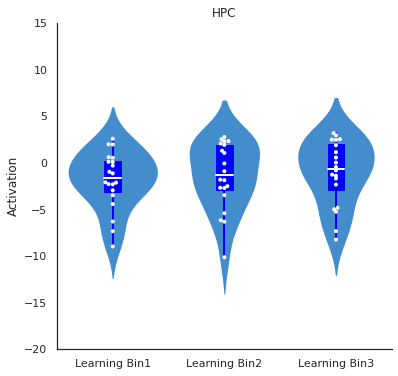

In [10]:
for d in ['bin1', 'bin2', 'bin3']:
    print("Mean {0}: ".format(d), np.mean(hp_chart['{0}'.format(d)]))
    print("STD {0}: ".format(d), np.std(hp_chart['{0}'.format(d)]))
    if stats.shapiro(hp_chart['{0}'.format(d)])[1] > 0.049:
        print("Shapiros {0}: ".format(d), stats.shapiro(hp_chart['{0}'.format(d)])[1])
    else:
        print("Shapiros {0}: ".format(d), stats.shapiro(hp_chart['{0}'.format(d)])[1], "**")
    print("")    
print(AnovaRM(data=df_hp_anova, depvar='activation', subject='subjid', within=['bin']).fit()) #repeated measures ANOVA
print("Bin3 vs. Bin1: ", stats.ttest_rel(hp_chart['bin3'], hp_chart['bin1']))
cohens_d = ((np.average(hp_chart['bin3']) - np.average(hp_chart['bin1'])) 
            / (sqrt((np.std(hp_chart['bin3'],ddof=1))**2+np.std(hp_chart['bin1'],ddof=1)**2)/2))
print("Cohen's d = ", cohens_d)
N = 3
conditions = ['Learning Bin1', 'Learning Bin2', 'Learning Bin3']
hp_allsubjs = [hp_chart['bin1'], hp_chart['bin2'], hp_chart['bin3']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (6,6))
sns.despine(top=True)
sns.violinplot(data = hp_allsubjs, color = "#278fea", inner = None, linewidth = 0, saturation = 0.7)
ax.boxplot(hp_allsubjs, whis = 'range', positions = ind, widths = 0.15, patch_artist = True,
           showcaps = False, boxprops = dict(color = "blue", facecolor = "blue"),
           whiskerprops = dict(color = "blue", linewidth = 2, linestyle = "-"),
           medianprops=dict(color = "w", linewidth = 2))
sns.swarmplot(data = hp_allsubjs, size = 4, color = "white", edgecolor = "gray")
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylabel("Activation")
ax.set_title("HPC")
ax.set_ylim(-20,15)
plt.savefig("/home/arenf001/figs/BINS_C_hpc.png", dpi = 1000)
plt.show()

## Caudate

In [11]:
caud_chart = {}
for x in ['bin1', 'bin2', 'bin3']:
    caud_chart['{0}'.format(x)] = all_data_df['caud_all_{0}'.format(x)] 
caud_chart_df = pd.DataFrame.from_dict(caud_chart)

In [12]:
caud_chart_df

,bin1,bin2,bin3
0,6.675294,6.453128,5.324928
1,-3.476489,-5.586509,-4.032398
2,4.060510,0.995374,-0.338746
3,5.617901,5.251513,2.895421
4,-3.126273,-4.701832,-4.072964
5,5.405715,6.774748,2.640830
6,3.340371,0.850777,1.588379
7,2.080846,-0.943898,-0.308655
8,0.598740,1.688267,2.510521
9,2.050790,-0.185505,0.659674


In [13]:
caud_anova = {'subjid':[], 'bin':[], 'activation':[]} #reorganizing data for Repeated Measures ANOVA

for i in range(len(sids)):
    for j in range(3):
        caud_anova['subjid'].append(sids[i])
        caud_anova['bin'].append(j+1)
        caud_anova['activation'].append(caud_chart_df['bin{0}'.format(j+1)][i])
df_caud_anova = pd.DataFrame(caud_anova)

Mean bin1:  3.210099979117513
STD bin1:  3.015888896660472
Shapiros bin1:  0.2819756865501404

Mean bin2:  2.1858780689537527
STD bin2:  3.7678795637847116
Shapiros bin2:  0.07419154047966003

Mean bin3:  1.7598030544817447
STD bin3:  3.21964504330251
Shapiros bin3:  0.0959739163517952

              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
bin  4.0925 2.0000 38.0000 0.0246

Bin2 vs. Bin1:  Ttest_relResult(statistic=-1.9125788875019583, pvalue=0.07099727892947044)
Bin3 vs. Bin2:  Ttest_relResult(statistic=-0.70139484877019, pvalue=0.4915590377002439)
Bin3 vs. Bin1:  Ttest_relResult(statistic=-3.6389085854345367, pvalue=0.0017467004017058974) **
Cohen's d =  -0.6408528750923486


<ipython-input-14-c711d4a9c116>:23: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(caud_allsubjs, whis = 'range', positions = ind, widths = 0.15, patch_artist = True,


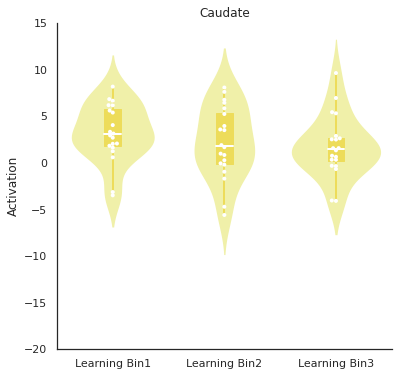

In [14]:
for d in ['bin1', 'bin2', 'bin3']:
    print("Mean {0}: ".format(d), np.mean(caud_chart['{0}'.format(d)]))
    print("STD {0}: ".format(d), np.std(caud_chart['{0}'.format(d)]))
    if stats.shapiro(hp_chart['{0}'.format(d)])[1] > 0.049:
        print("Shapiros {0}: ".format(d), stats.shapiro(hp_chart['{0}'.format(d)])[1])
    else:
        print("Shapiros {0}: ".format(d), stats.shapiro(hp_chart['{0}'.format(d)])[1], "**")
    print("")
print(AnovaRM(data=df_caud_anova, depvar='activation', subject='subjid', within=['bin']).fit()) #repeated measures ANOVA
print("Bin2 vs. Bin1: ", stats.ttest_rel(caud_chart['bin2'], caud_chart['bin1']))
print("Bin3 vs. Bin2: ", stats.ttest_rel(caud_chart['bin3'], caud_chart['bin2']))
print("Bin3 vs. Bin1: ", stats.ttest_rel(caud_chart['bin3'], caud_chart['bin1']), "**")
cohens_d = ((np.average(caud_chart['bin3']) - np.average(caud_chart['bin1'])) 
            / (sqrt((np.std(caud_chart['bin3'],ddof=1))**2+np.std(caud_chart['bin1'],ddof=1)**2)/2))
print("Cohen's d = ", cohens_d)
N = 3
conditions = ['Learning Bin1', 'Learning Bin2', 'Learning Bin3']
caud_allsubjs = [caud_chart['bin1'], caud_chart['bin2'], caud_chart['bin3']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (6,6))
sns.despine(top=True)
sns.violinplot(data = caud_allsubjs, color = "#fcfc9d", inner = None, linewidth = 0)
ax.boxplot(caud_allsubjs, whis = 'range', positions = ind, widths = 0.15, patch_artist = True,
           showcaps = False, boxprops = dict(color = "#eddc5a", facecolor = "#eddc5a"),
           whiskerprops = dict(color = "#eddc5a", linewidth = 2, linestyle = "-"), 
           medianprops = dict(color = "w", linewidth = 2))
sns.swarmplot(data = caud_allsubjs, size = 4, color = "white", edgecolor = "gray")
ax.set_xticklabels(conditions)
ax.set_ylabel("Activation")
ax.set_title("Caudate")
ax.set_ylim(-20,15)
plt.savefig("/home/arenf001/figs/BINS_C_caud.png", dpi = 1000)
plt.show()

## mPFC

In [15]:
mpfc_chart = {}
for x in ['bin1', 'bin2', 'bin3']:
    mpfc_chart['{0}'.format(x)] = all_data_df['mpfc_all_{0}'.format(x)] 
mpfc_chart_df = pd.DataFrame.from_dict(mpfc_chart)

In [16]:
mpfc_chart_df

,bin1,bin2,bin3
0,1.136066,5.165363,4.923677
1,-6.165132,-6.126591,-5.567019
2,1.676648,0.764963,-1.576147
3,0.728340,1.682699,-0.049334
4,-3.197242,-2.953372,-1.676982
5,5.024624,2.256644,5.410164
6,1.284856,2.284809,2.632523
7,-5.173834,-8.100119,-6.795107
8,-8.594981,-10.561240,-8.528122
9,-1.540455,-1.150916,0.328049


In [17]:
mpfc_anova = {'subjid':[], 'bin':[], 'activation':[]} #reorganizing data for Repeated Measures ANOVA

for i in range(len(sids)):
    for j in range(3):
        mpfc_anova['subjid'].append(sids[i])
        mpfc_anova['bin'].append(j+1)
        mpfc_anova['activation'].append(mpfc_chart_df['bin{0}'.format(j+1)][i])
df_mpfc_anova = pd.DataFrame(mpfc_anova)

Mean bin1:  -0.9648430857807397
STD bin1:  4.018860144256531
Shapiros bin1:  0.2819756865501404

Mean bin2:  -0.8634935455396772
STD bin2:  4.59995652164204
Shapiros bin2:  0.07419154047966003

Mean bin3:  -0.36069020368158816
STD bin3:  4.32497898361907
Shapiros bin3:  0.0959739163517952

              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
bin  0.7451 2.0000 38.0000 0.4815



<ipython-input-24-f33ff2386ee7>:17: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(mpfc_allsubjs, whis = 'range', positions = ind, widths = 0.15, patch_artist = True,


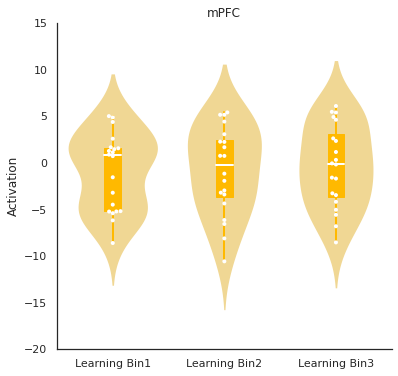

In [24]:
for d in ['bin1', 'bin2', 'bin3']:
    print("Mean {0}: ".format(d), np.mean(mpfc_chart['{0}'.format(d)]))
    print("STD {0}: ".format(d), np.std(mpfc_chart['{0}'.format(d)]))
    if stats.shapiro(hp_chart['{0}'.format(d)])[1] > 0.049:
        print("Shapiros {0}: ".format(d), stats.shapiro(hp_chart['{0}'.format(d)])[1])
    else:
        print("Shapiros {0}: ".format(d), stats.shapiro(hp_chart['{0}'.format(d)])[1], "**")
    print("")
print(AnovaRM(data=df_mpfc_anova, depvar='activation', subject='subjid', within=['bin']).fit()) #repeated measures ANOVA
N = 3
conditions = ['Learning Bin1', 'Learning Bin2', 'Learning Bin3']
mpfc_allsubjs = [mpfc_chart['bin1'], mpfc_chart['bin2'], mpfc_chart['bin3']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (6,6))
sns.despine(top=True)
sns.violinplot(data = mpfc_allsubjs, color = "#ffde85", inner = None, linewidth = 0)
ax.boxplot(mpfc_allsubjs, whis = 'range', positions = ind, widths = 0.15, patch_artist = True,
           showcaps = False, boxprops = dict(color = "#ffb900", facecolor = "#ffb900"),
           whiskerprops = dict(color = "#ffb900", linewidth = 2, linestyle = "-"), 
           medianprops = dict(color = "w", linewidth = 2))
sns.swarmplot(data = mpfc_allsubjs, size = 4, color = "white", edgecolor = "gray")
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylabel("Activation")
ax.set_title("mPFC")
ax.set_ylim(-20,15)
plt.savefig("/home/arenf001/figs/BINS_C_mpfc.png", dpi = 800)
plt.show()

## Putamen

In [25]:
put_chart = {}
for x in ['bin1', 'bin2', 'bin3']:
    put_chart['{0}'.format(x)] = all_data_df['put_all_{0}'.format(x)] 
put_chart_df = pd.DataFrame.from_dict(put_chart)

In [26]:
put_chart_df

,bin1,bin2,bin3
0,4.920220,5.393476,6.166033
1,-6.163809,-5.877858,-5.208616
2,2.521552,-1.818639,0.767422
3,-1.907218,-2.467779,-2.986098
4,-1.237310,-2.449258,-1.503600
5,7.277982,8.696833,9.601138
6,0.539105,0.784422,0.848256
7,-4.082526,-4.346000,-4.438423
8,-1.492252,-1.675038,-0.745982
9,1.002779,0.447356,2.021662


In [27]:
put_anova = {'subjid':[], 'bin':[], 'activation':[]} #reorganizing data for Repeated Measures ANOVA

for i in range(len(sids)):
    for j in range(3):
        put_anova['subjid'].append(sids[i])
        put_anova['bin'].append(j+1)
        put_anova['activation'].append(put_chart_df['bin{0}'.format(j+1)][i])
df_put_anova = pd.DataFrame(put_anova)

Mean bin1:  0.7500855894759297
STD bin1:  3.15345210322556
Shapiros bin1:  0.2819756865501404

Mean bin2:  0.6310598343610764
STD bin2:  3.6113681026342577
Shapiros bin2:  0.07419154047966003

Mean bin3:  1.0024213858880102
STD bin3:  3.4488141562077224
Shapiros bin3:  0.0959739163517952

              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
bin  0.4945 2.0000 38.0000 0.6137

Bin1 vs. Bin2:  Ttest_relResult(statistic=0.26870874430726693, pvalue=0.791049858280173)
Bin1 vs. Bin3:  Ttest_relResult(statistic=-0.9019501863819787, pvalue=0.37837550735830483)


<ipython-input-28-3206f5ba4b4b>:19: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(put_allsubjs, whis = 'range', positions = ind, widths = 0.15, patch_artist = True,


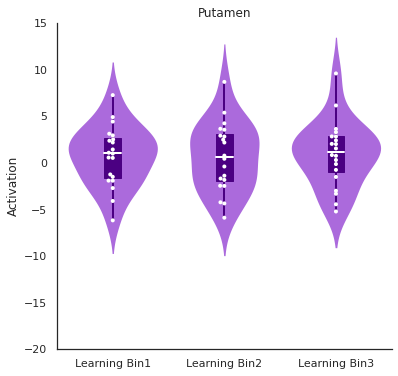

In [28]:
for d in ['bin1', 'bin2', 'bin3']:
    print("Mean {0}: ".format(d), np.mean(put_chart['{0}'.format(d)]))
    print("STD {0}: ".format(d), np.std(put_chart['{0}'.format(d)]))
    if stats.shapiro(hp_chart['{0}'.format(d)])[1] > 0.049:
        print("Shapiros {0}: ".format(d), stats.shapiro(hp_chart['{0}'.format(d)])[1])
    else:
        print("Shapiros {0}: ".format(d), stats.shapiro(hp_chart['{0}'.format(d)])[1], "**")
    print("")
print(AnovaRM(data=df_put_anova, depvar='activation', subject='subjid', within=['bin']).fit()) #repeated measures ANOVA
print("Bin1 vs. Bin2: ", stats.ttest_rel(put_chart['bin1'], put_chart['bin2']))
print("Bin1 vs. Bin3: ", stats.ttest_rel(put_chart['bin1'], put_chart['bin3']))
N = 3
conditions = ['Learning Bin1', 'Learning Bin2', 'Learning Bin3']
put_allsubjs = [put_chart['bin1'], put_chart['bin2'],  put_chart['bin3']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (6,6))
sns.despine(top=True)
sns.violinplot(data = put_allsubjs, color = "#af52f4", inner = None, linewidth = 0, saturation = 0.7)
ax.boxplot(put_allsubjs, whis = 'range', positions = ind, widths = 0.15, patch_artist = True,
           showcaps = False, boxprops = dict(color = "indigo", facecolor = "indigo"),
           whiskerprops = dict(color = "indigo", linewidth = 2, linestyle = "-"),
           medianprops = dict(color = "w", linewidth = 2))
sns.swarmplot(data = put_allsubjs, size = 4, color = "white", edgecolor = "gray")           
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylabel("Activation")
ax.set_title("Putamen")
ax.set_ylim(-20,15)
plt.savefig("/home/arenf001/figs/BINS_C_put.png", dpi = 800)
plt.show()